# Simulation d'images aériennes

Ce carnet Jupyter reprend le [modèle Seg2Sat](https://github.com/RubenGres/Seg2Sat), développé par Ruben Gres, ingénieur IA à l'IGN. Seg2Sat est un réseau de neurones profond, dérivé de Stable Diffusion, permettant de générer des images aériennes semblables à celles de la BD ORTHO de l'IGN. Le modèle prend en entrée des cartes sémantiques détaillant l'occupation des sols de chaque pixel.

Nous allons voir les images que Seg2Sat est en mesure de générer et comment tirer parti du contrôle offert par les cartes sémantiques.

Commençons par installer quelques packages Python utiles, notamment développés par HuggingFace :

In [ ]:
!pip install diffusers
!pip install transformers
!pip install accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 26.8 MB/s eta 0:00:00


On peut ensuite importer ces bibliothèques. En particulier, Seg2Sat est construit comme une instance de ControlNet, une variante de Stable Diffusion permettant le conditionnement de la génération à des entrées données (ici, les cartes sémantiques) :

In [ ]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
from diffusers import StableDiffusionControlNetPipeline
from diffusers.utils import load_image
import torch

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Nous pouvons maintenant instancier le *pipeline* Stable Diffusion/ControlNet correspondant au modèle pré-entraîné Seg2Sat. Cette manipulation est un peu technique et est liée à la bibliothèque *transformers* de HuggingFace, qui est une surcouche d'abstraction implémentant de nombreux modèles profonds.

Cette étape peut durer plusieurs minutes, notamment la phase de téléchargement des poids du Seg2Sat pré-entraîné.

In [ ]:
# utilise le GPU s'il est disponible
device = "cuda:0" if torch.cuda.is_available() else "cpu"
# /!\ attention : les calculs sont *très* lents sur CPU

controlnet = ControlNetModel.from_pretrained("rgres/sd-controlnet-aerialdreams", torch_dtype=torch.float16).to(device)

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-1-base", controlnet=controlnet, torch_dtype=torch.float16
).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.04k [00:00<?, ?B/s]

An error occurred while trying to fetch rgres/sd-controlnet-aerialdreams: rgres/sd-controlnet-aerialdreams does not appear to have a file named diffusion_pytorch_model.safetensors.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


diffusion_pytorch_model.bin:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/543 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/807 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/346 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/911 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Nous pouvons ensuite charger une image arbitraire. Ici, il s'agit d'une des cartes sémantiques d'exemple du jeu de données utilisé pour entraîner Seg2Sat :

In [ ]:
seg_url = "https://github.com/RubenGres/Seg2Sat/blob/main/images/fig1/0/mask.png?raw=true"
image = load_image(seg_url)
image

  0%|          | 0/20 [00:00<?, ?it/s]

La génération s'effectue simplement en passant l'image au *pipe* définit ci-dessus. En plus de la carte sémantique, il est possible de passer un *prompt*, c'est-à-dire une description textuelle de l'image à générer. N'hésitez pas à expérimenter avec plusieurs variantes.

In [ ]:
image = pipe(
   prompt="High resolution image, 4K, ultra detailed, aerial view of 31 Rue Molière, France.", num_inference_steps=20, image=image
).images[0]


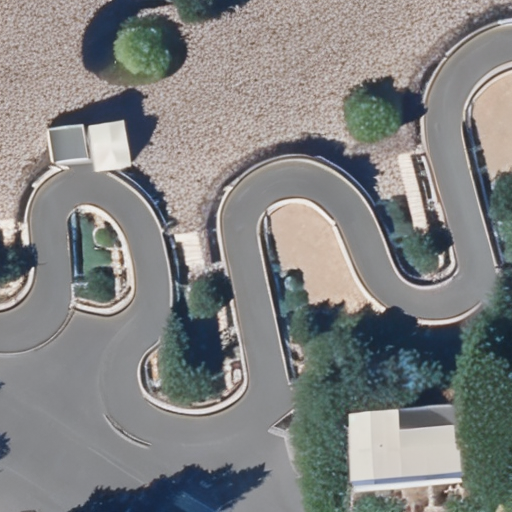

In [ ]:
image

Le bloc de code ci-dessous permet d'afficher un canevas sur lequel il est possible de dessiner sa propre carte sémantique. Celle-ci est ensuite sauvegardée localement sur le disque, sous le nom de fichier `drawing.png`.

In [ ]:
#@title Éditeur de cartes
from google.colab import output
from base64 import b64decode
from IPython.display import HTML
import os
import shutil
import uuid
COLAB_HTML_ROOT = "/usr/local/share/jupyter/nbextensions/google.colab/"

def moveToExt(filename:str) -> str:
  if not os.path.exists(filename):
    print("Image file not found")
    return None

  target = os.path.basename(filename)
  target = os.path.join(COLAB_HTML_ROOT, str(uuid.uuid4()) + target)

  shutil.copyfile(filename,target)
  print("moved to ext")
  return target


def draw(filename='drawing.png', color="black", bg_color="transparent",w=256, h=256, line_width=1,loop=False):
  real_filename = os.path.realpath(filename)
  html_filename = real_filename
  html_real_filename = html_filename
  if os.path.exists(real_filename):
    html_real_filename = moveToExt(real_filename)
    html_filename = html_real_filename.replace("/usr/local/share/jupyter","")


  canvas_html = f"""
  <canvas width={w} height={h}></canvas>

  <div>
    <datalist id="ColorList">
      <option value="#db0e9a" label="building"/>
      <option value="#938e7b" label="pervious surface""/>
      <option value="#f80c00" label="impervious surface"/>
      <option value="#a97101" label="bare soil"/>
      <option value="#1553ae" label="water"/>
      <option value="#194a26" label="coniferous"/>
      <option value="#46e483" label="deciduous"/>
      <option value="#f3a60d" label="brushwood"/>
      <option value="#660082" label="vineyard"/>
      <option value="#55ff00" label="herbaceous vegetation"/>
      <option value="#fff30d" label="agricultural land"/>
      <option value="#e4df7c" label="plowed land"/>
      <option value="#3de6eb" label="swimming pool"/>
      <option value="#ffffff" label="snow"/>
      <option value="#8ab3a0" label="clear cut"/>
      <option value="#6b714f" label="mixed"/>
      <option value="#c5dc42" label="ligneous"/>
      <option value="#9999ff" label="greenhouse"/>
      <option value="#000000" label="other"/>
    </datalist>
    <label for="strokeColor">Stroke</label>
    <input type="color" value="{color}" id="strokeColor" list="#ColorList">

    <label for="bgColor">Background</label>
    <input type="color" value="{bg_color}" id="bgColor">
  </div>
  <div class="slidecontainer">
  <label for="lineWidth" id="lineWidthLabel">{line_width}px</label>
    <input type="range" min="1" max="35" value="1" class="slider" id="lineWidth">
  </div>
  <div>
    <button id="loadImage">Reload from disk</button>
    <button id="reset">Reset</button>
    <button id="save">Save</button>
    <button id="exit">Exit</button>
  </div>
  <script>
   function loadImage(url) {{
  return new Promise(r => {{ let i = new Image(); i.onload = (() => r(i)); i.src = url; }});
}}


    var canvas = document.querySelector('canvas')
    var ctx = canvas.getContext('2d')
    ctx.lineWidth = {line_width}
    ctx.fillStyle = "{bg_color}";

    ctx.fillRect(0, 0, canvas.width, canvas.height);
    ctx.strokeStyle = "{color}";
    var strokeColor = document.querySelector('#strokeColor')
    var bgColor = document.querySelector('#bgColor')
    var slider = document.getElementById("lineWidth");
    slider.oninput = function() {{
      ctx.lineWidth = this.value;
      lineWidthLabel.innerHTML = `${{this.value}}px`
    }}
    function updateStroke(event){{
        ctx.strokeStyle = event.target.value
    }}
    function updateBG(event){{
        ctx.fillStyle = event.target.value
    }}

    bgColor.addEventListener("change", updateBG, false);
    strokeColor.addEventListener("change", updateStroke, false);

    var clear_button = document.querySelector('#reset')
    var reload_img_button = document.querySelector('#loadImage')
    var button = document.querySelector('#save')
    var exit_button = document.querySelector('#exit')
    var mouse = {{x: 0, y: 0}}
    canvas.addEventListener('mousemove', function(e) {{
      mouse.x = e.pageX - this.offsetLeft
      mouse.y = e.pageY - this.offsetTop
    }})
    canvas.onmousedown = ()=>{{
      ctx.beginPath()
      ctx.moveTo(mouse.x, mouse.y)
      canvas.addEventListener('mousemove', onPaint)
    }}
    canvas.onmouseup = ()=>{{
      canvas.removeEventListener('mousemove', onPaint)
    }}
    var onPaint = ()=>{{
      ctx.lineTo(mouse.x, mouse.y)
      ctx.stroke()
    }}
    reload_img_button.onclick = async ()=>{{
      console.log("Reloading Image {html_filename}")
      let img = await loadImage('{html_filename}');
      console.log("Loaded image")
      ctx.drawImage(img, 0, 0);
    }}

    clear_button.onclick = ()=>{{
        console.log('Clearing Screen')
        ctx.clearRect(0, 0, canvas.width, canvas.height);
        ctx.fillRect(0, 0, canvas.width, canvas.height);
      }}
      canvas.addEventListener('load', function() {{
      console.log('All assets are loaded')
    }})
    var data = new Promise(resolve=>{{
      button.onclick = ()=>{{
        resolve(canvas.toDataURL('image/png'))
      }}
      exit_button.onclick = ()=>{{
      resolve()
    }}

    }})

    // window.onload = async ()=>{{
    //   console.log("loaded")
    //   let img = await loadImage('{html_filename}');
    //   ctx.drawImage(img, 0, 0);
    // }}


  </script>
  """

  display(HTML(canvas_html))
  print("Evaluating JS")

  data = output.eval_js("data")
  if data:
    print("Saving Sketch")
    binary = b64decode(data.split(',')[1])
    # filename = html_real_filename if loop else filename
    with open(filename, 'wb') as f:
      f.write(binary)
    #return len(binary)
    if loop:
      output.clear()
      return True
  return False

In [ ]:
draw(bg_color="white")

Evaluating JS


False

Il est alors possible d'ouvrir la carte sémantique modifiée et de la passer à Seg2Sat pour générer une nouvelle image :

In [ ]:
import PIL
image = PIL.Image.open("drawing.png")

image = pipe(
   prompt="High resolution image, 4K, ultra detailed, aerial view of 31 Rue Molière, France.", num_inference_steps=20, image=image
).images[0]


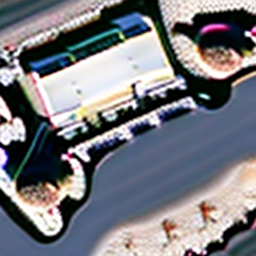

In [ ]:
image

Essayez notamment de modifier seulement un peu les cartes sémantiques pour générer des variantes d'images aériennes. Par exemple, essayez d'ajouter ou de retirer des bâtiments dans l'image. Expérimentez différentes stratégies !